In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import urllib
from requests import get
from requests.exceptions import RequestException
from contextlib import closing

import requests
import urllib.request
import time
from bs4 import BeautifulSoup
import lxml.html as lh

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error as MSE

from  keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K
from keras import layers
from keras.initializers import Zeros
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.layers import LSTM

In [10]:
import os

In [11]:
os.listdir()

['ML in Finance.ipynb',
 'Scraping.ipynb',
 'Time Series Analysis.ipynb',
 '.gitattributes',
 'data_gen.ipynb',
 '.ipynb_checkpoints',
 '.git']

In [13]:
from data_gen.ipynb import get_data,usd_gbp_new

ModuleNotFoundError: No module named 'data_gen'

In [11]:
ex_data = usd_gbp_new()

In [12]:
ex_data.columns

Index(['Date', 'Rate'], dtype='object')

In [13]:
ex_data.tail()

,Date,Rate
355,2019-12-22,1.3007
356,2019-12-23,1.2946
357,2019-12-24,1.2933
358,2019-12-25,1.2972
359,2019-12-26,1.2996


In [14]:
# ex_data['Rate'] = ex_data['Rate'] *10000

In [15]:
ex_data.index

RangeIndex(start=0, stop=360, step=1)

In [20]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10

In [17]:
ex_data.Rate.min(),ex_data.Rate.max()

('1.2033', '1.347')

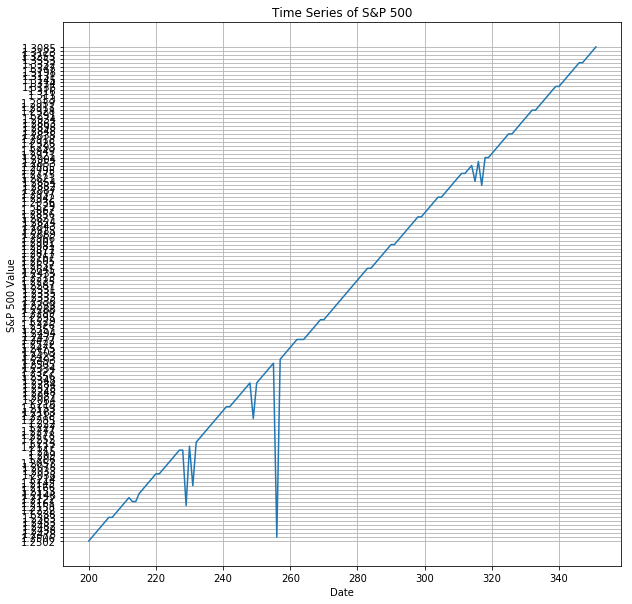

In [18]:
plt.plot(ex_data.iloc[200:352,1])
plt.title('Time Series of S&P 500') 
plt.ylabel('S&P 500 Value')
plt.xlabel('Date')
# plt.ylim(ex_data['Rate'].min(),ex_data['Rate'].max() )
plt.grid()
plt.show()

References

https://docs.python-guide.org/scenarios/scrape/

https://towardsdatascience.com/web-scraping-html-tables-with-python-c9baba21059

### Data for last 180 days

In [15]:
def get_data():
    source=urllib.request.urlopen('https://www.exchangerates.org.uk/GBP-USD-exchange-rate-history.html')
    html=source.read()
    
    soup = BeautifulSoup(html,"lxml")
    #(soup.prettify())
    soup.a
    
    data_table=soup.find('table',{"id":'hist'})
    #print (data_table)
    
    day=[]
    rate=[]
    
    for counter,row in enumerate(data_table.findAll('tr')):
        cells=row.findAll('td')
        if len(cells)==3:
            day.append(((cells[0].find(text=True)).split(None,1))[1])
            rate.append(float(((cells[1].find(text=True)).split(' '))[3]))
            
    date=[]
    for counter,object_ in enumerate(day):
        date.append(pd.datetime.strptime(object_, "%d %B %Y"))
        
    rate_data=pd.DataFrame({'Day':date,'Rate':rate})
    rate_data=rate_data.set_index('Day')
    rate_data_full=rate_data.reindex(index=rate_data.index[::-1])
    
    return rate_data_full

In [16]:
rate_data = get_data()

In [17]:
rate_data.head()

,Rate
Day,
2019-06-30,1.2697
2019-07-01,1.2645
2019-07-02,1.2597
2019-07-03,1.2579
2019-07-04,1.2582


In [18]:
rate_data.index

DatetimeIndex(['2019-06-30', '2019-07-01', '2019-07-02', '2019-07-03',
               '2019-07-04', '2019-07-05', '2019-07-06', '2019-07-07',
               '2019-07-08', '2019-07-09',
               ...
               '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',
               '2019-12-21', '2019-12-22', '2019-12-23', '2019-12-24',
               '2019-12-25', '2019-12-26'],
              dtype='datetime64[ns]', name='Day', length=180, freq=None)

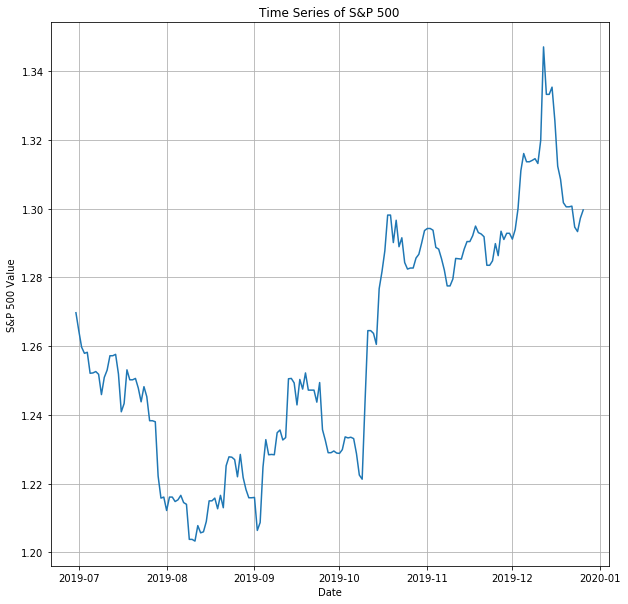

In [21]:
plt.plot(rate_data.Rate)
plt.title('Time Series of S&P 500') 
plt.ylabel('S&P 500 Value')
plt.xlabel('Date')
# plt.ylim(ex_data['Rate'].min(),ex_data['Rate'].max() )
plt.grid()
plt.show()

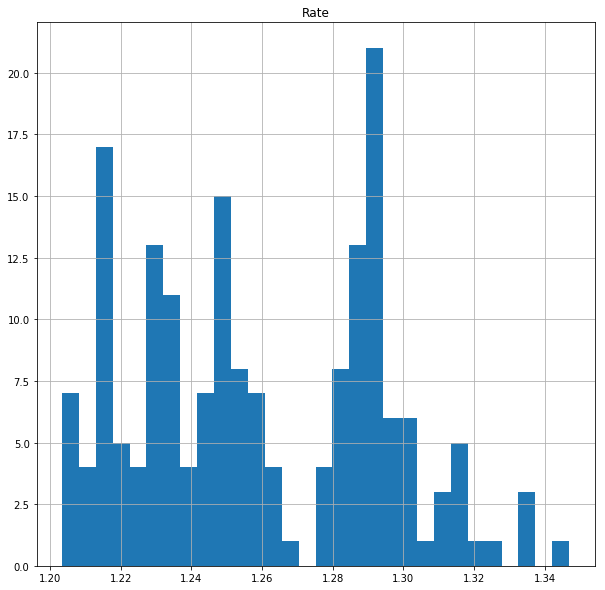

In [22]:
rate_data.hist(bins = 30)
plt.show()

In [23]:
df_test = adfuller(rate_data['Rate'], autolag='AIC')
result = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test[4].items():
    result['Critical Value (%s)'%key] = value
print (result)

Test Statistic                  -0.986816
p-value                          0.758042
#Lags Used                       1.000000
Number of Observations Used    178.000000
Critical Value (1%)             -3.467632
Critical Value (5%)             -2.877918
Critical Value (10%)            -2.575501
dtype: float64


In [24]:
rolling_mean = pd.Series.rolling(rate_data['Rate'],window= 10,center=False).mean()
plt.rcParams["figure.figsize"] = fig_size

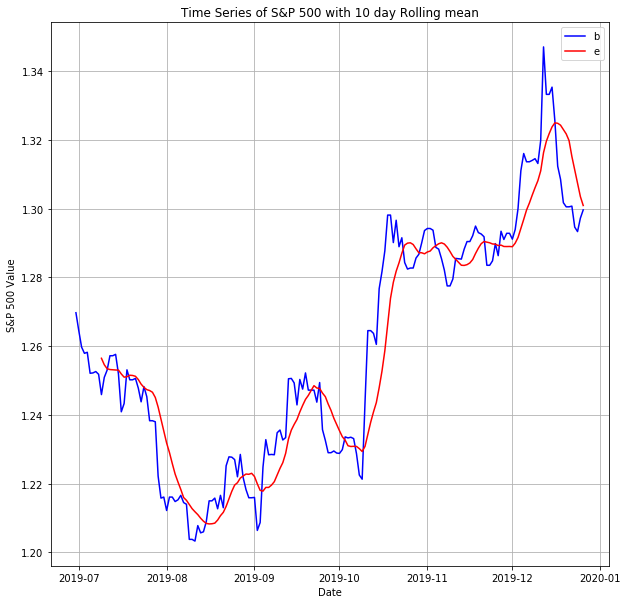

In [25]:
plt.plot(rate_data, color = 'blue', label = 'Normal')
plt.plot(rolling_mean, color = 'red', label = 'Rolling')
plt.legend('best')
plt.title('Time Series of S&P 500 with 10 day Rolling mean') 
plt.ylabel('S&P 500 Value')
plt.xlabel('Date')
plt.grid()
plt.show()


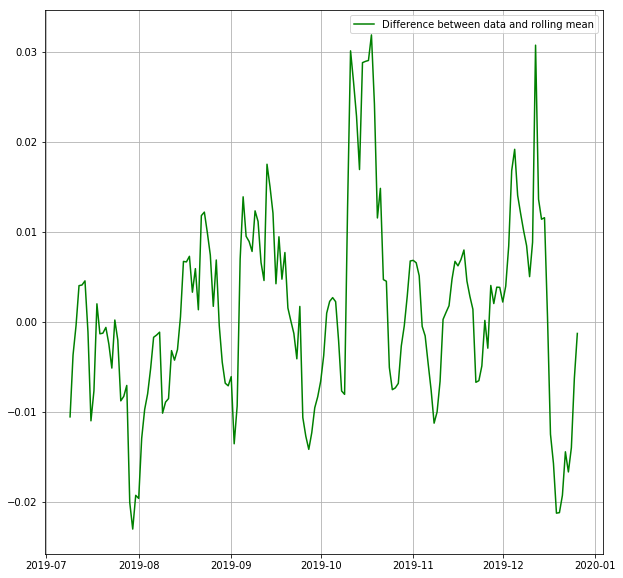

In [26]:
rolling_mean_diff = rate_data['Rate'] - rolling_mean
#plt.rcParams["figure.figsize"] = fig_size
# plt.plot(sp500, color = 'blue', label = 'Normal')
# plt.plot(rolling_mean, color = 'red', label = 'Rolling')
plt.plot(rolling_mean_diff, color='green',label='Difference between data and rolling mean')
plt.legend(loc='best')
plt.grid()
plt.show()
rolling_mean_diff.dropna(inplace=True)


In [27]:
df_rmean_test = adfuller(rolling_mean_diff, autolag='AIC')
result = pd.Series(df_rmean_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test[4].items():
    result['Critical Value (%s)'%key] = value
print (result)


Test Statistic                  -3.960632
p-value                          0.001631
#Lags Used                       1.000000
Number of Observations Used    169.000000
Critical Value (1%)             -3.467632
Critical Value (5%)             -2.877918
Critical Value (10%)            -2.575501
dtype: float64


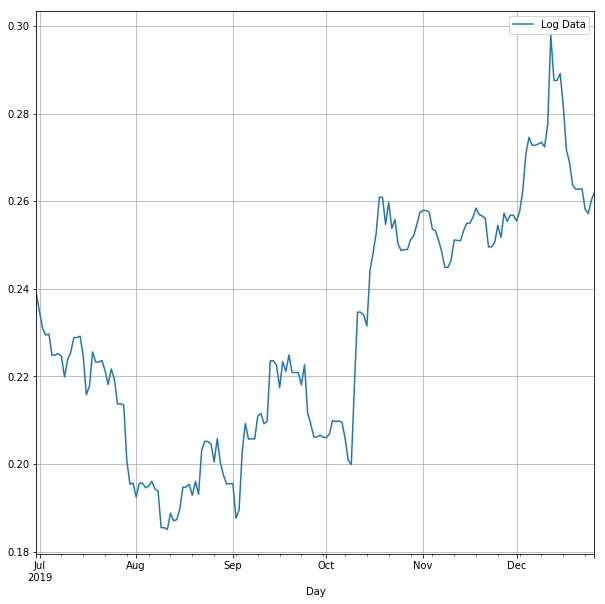

In [28]:
rate_data_log = np.log(rate_data['Rate'])

rate_data_log.plot(label='Log Data')
plt.legend(loc='best')
plt.grid()
plt.show()


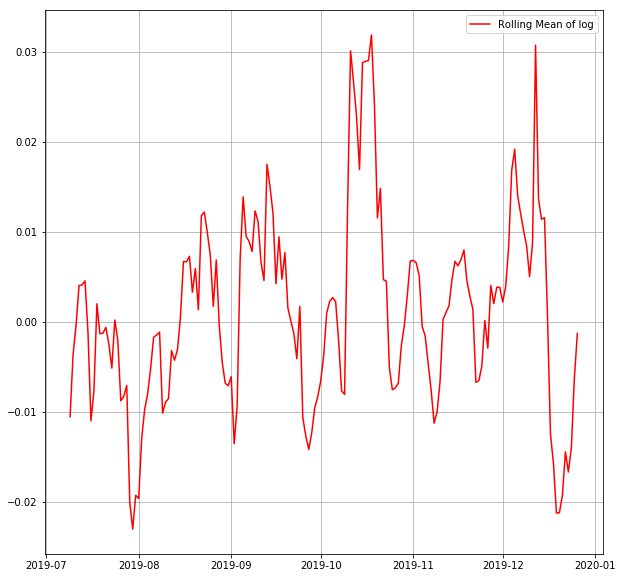

In [29]:
log_rolling_mean=pd.Series.rolling(rate_data_log,window=10,center=False).mean()
plt.rcParams["figure.figsize"] = fig_size
log_rolmean_diff=rate_data_log-log_rolling_mean
log_rmean_diff= plt.plot(rolling_mean_diff, color='red', label='Rolling Mean of log')
plt.legend(loc='best')
plt.grid()
plt.show()
log_rolmean_diff.dropna(inplace=True)


In [30]:
df_test_log = adfuller(log_rolmean_diff, autolag='AIC')
result_log = pd.Series(df_test_log[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_log[4].items():
    result_log['Critical Value (%s)'%key] = value
print (result_log)

Test Statistic                  -3.973434
p-value                          0.001556
#Lags Used                       1.000000
Number of Observations Used    169.000000
Critical Value (1%)             -3.469648
Critical Value (5%)             -2.878799
Critical Value (10%)            -2.575971
dtype: float64


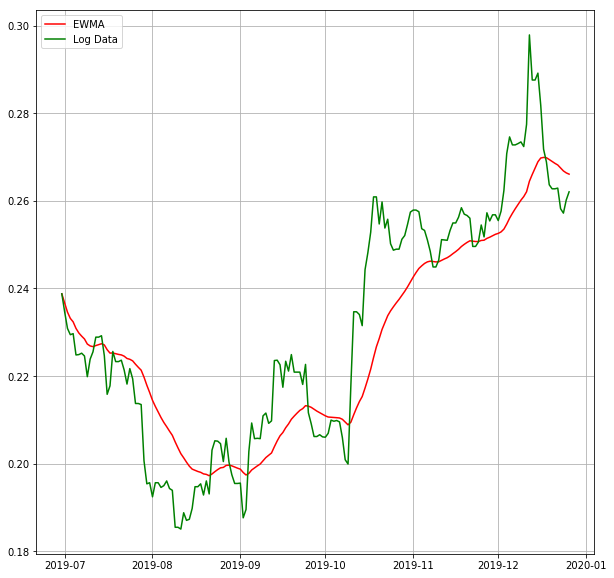

In [31]:
ewma_data=pd.Series.ewm(rate_data_log,halflife=10,min_periods=0,adjust=True,ignore_na=False).mean()

# rate_data_log.plot(label='Log Data')
# Calculate EWMA and plot
plt.plot(ewma_data, color='red',label='EWMA')
plt.plot(rate_data_log, color='green',label='Log Data')
plt.legend()
plt.legend(loc='best')
plt.grid()
plt.show()

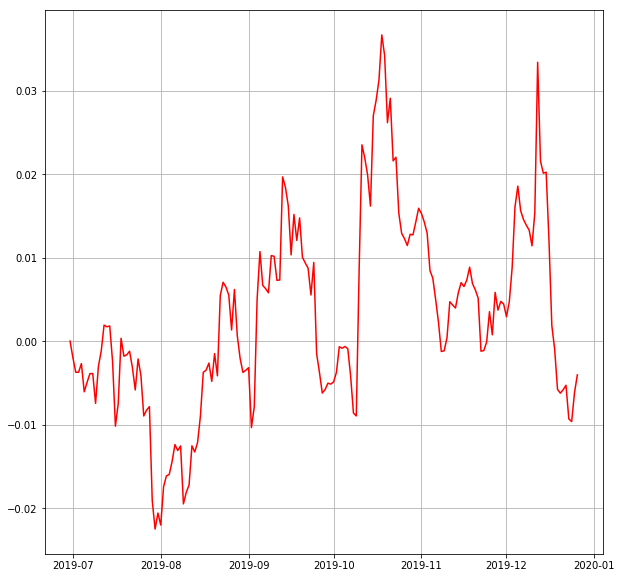

In [32]:
ewma_diff=rate_data_log-ewma_data
plt.rcParams["figure.figsize"] = fig_size
plt.plot(ewma_diff, color='red')
plt.grid()
plt.show()



In [33]:
df_test_ewma = adfuller(ewma_diff, autolag='AIC')
result_ewma = pd.Series(df_test_ewma[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_ewma[4].items():
    result_ewma['Critical Value (%s)'%key] = value
print (result_ewma)

Test Statistic                  -2.775129
p-value                          0.061915
#Lags Used                       1.000000
Number of Observations Used    178.000000
Critical Value (1%)             -3.467632
Critical Value (5%)             -2.877918
Critical Value (10%)            -2.575501
dtype: float64


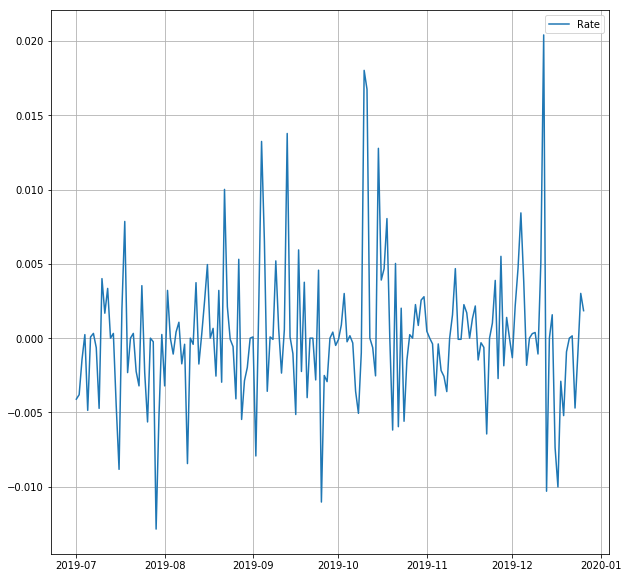

In [34]:
rate_log_diff = rate_data_log - rate_data_log.shift()
rate_log_diff.dropna(inplace=True)
plt.rcParams["figure.figsize"] = fig_size
plt.plot(rate_log_diff)
plt.legend('Log Data')
plt.legend(loc='best')
plt.grid()
plt.show()

In [35]:
df_test_logdiff = adfuller(rate_log_diff, autolag='AIC')
result_logdiff = pd.Series(df_test_logdiff[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_logdiff[4].items():
    result_logdiff['Critical Value (%s)'%key] = value
print (result_logdiff)

Test Statistic                -1.188003e+01
p-value                        6.208979e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.780000e+02
Critical Value (1%)           -3.467632e+00
Critical Value (5%)           -2.877918e+00
Critical Value (10%)          -2.575501e+00
dtype: float64


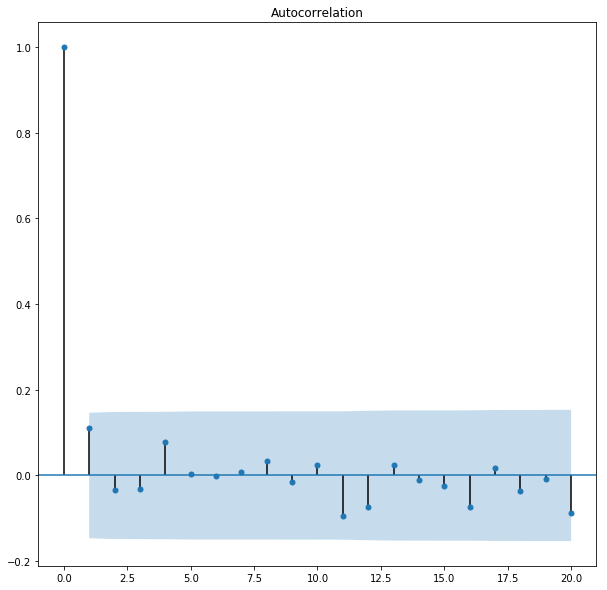

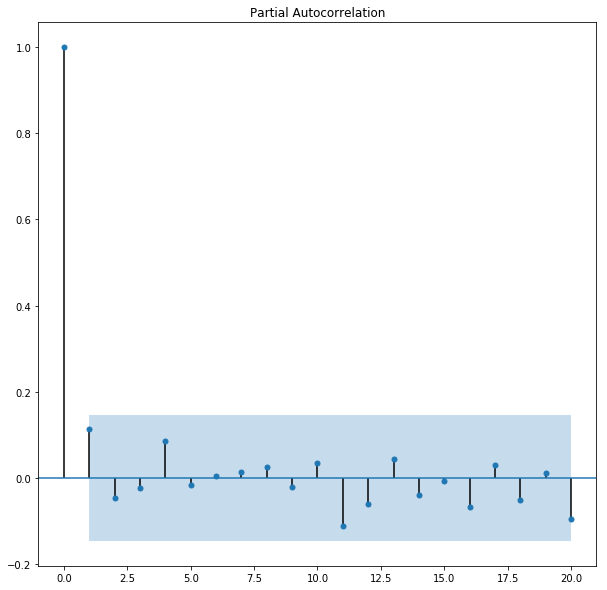

In [36]:
plot_acf(rate_log_diff,lags=20)
plt.show()

plot_pacf(rate_log_diff,lags=20)
plt.show()


In [37]:
rate_data_log= np.log(rate_data['Rate'])
decomposition = seasonal_decompose(rate_data_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid
rate_data_log

Day
2019-06-30    0.238781
2019-07-01    0.234677
2019-07-02    0.230874
2019-07-03    0.229444
2019-07-04    0.229682
                ...   
2019-12-22    0.262903
2019-12-23    0.258202
2019-12-24    0.257197
2019-12-25    0.260208
2019-12-26    0.262057
Name: Rate, Length: 180, dtype: float64

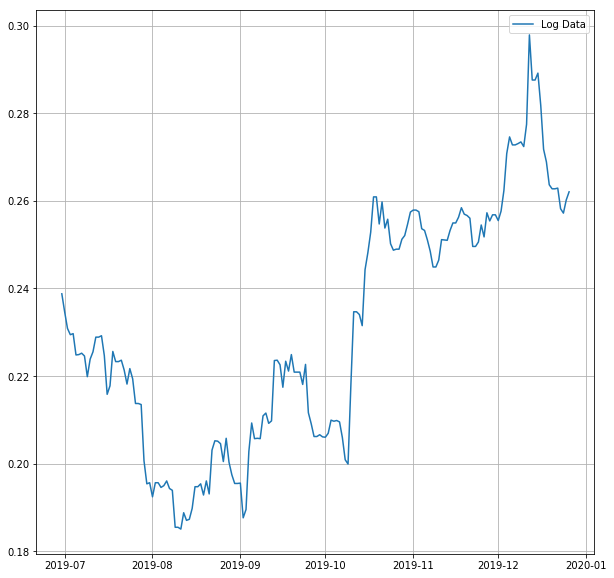

In [38]:
plt.rcParams["figure.figsize"] = fig_size
plt.plot(rate_data_log,label='Log Data')
plt.legend()
plt.grid()
plt.show()



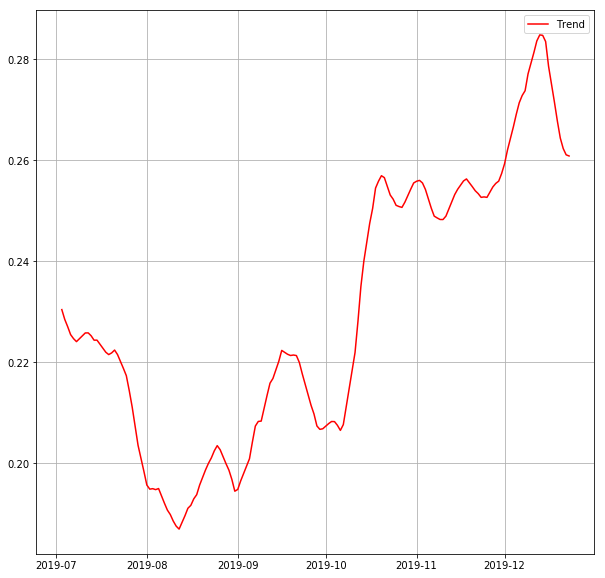

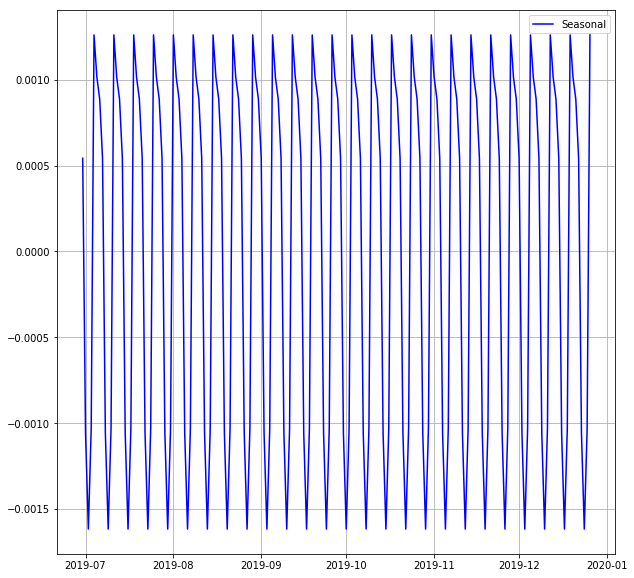

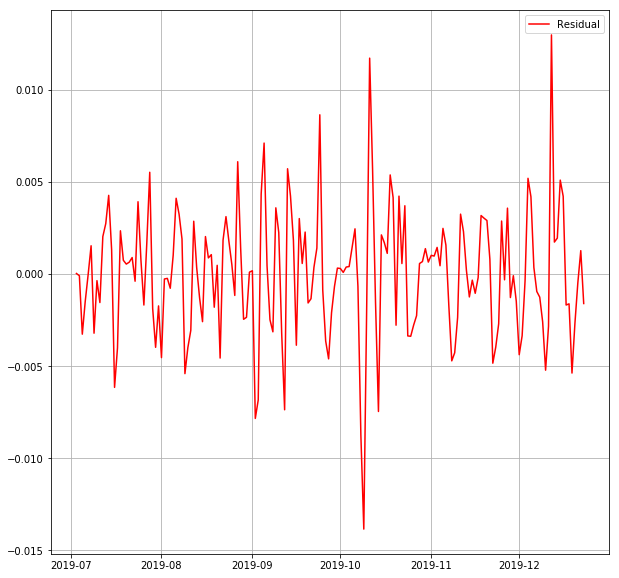

In [39]:
plt.plot(trend,color='red',label='Trend')
plt.legend()
plt.grid()
plt.show()

plt.plot(seasonal,color='Blue',label='Seasonal')
plt.legend()
plt.grid()
plt.show()

plt.plot(resid,color='red',label='Residual')
plt.legend()
plt.grid()
plt.show()


## ARIMA MODEL

In [61]:
data1 = rate_data_log.values
train = list(data1[0:125])
train_ = list(data1[0:125])
test = list(data1[125:])
otest = list(data1[125:0])

train_list = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(np.array(train),order=(1,1,0))
    fit = model.fit()
    forecast = float(fit.forecast()[0])
    predictions.append(forecast)
    train.append(float(test[t]))

/Users/ameyapatankar/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/ameyapatankar/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/ameyapatankar/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. I

In [62]:
model = ARIMA(np.array(train),order=(1,1,0))
fit = model.fit()
full_predictions=list(fit.forecast(34)[0])

/Users/ameyapatankar/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/ameyapatankar/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/ameyapatankar/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. I

Mean squared error: 0.000035


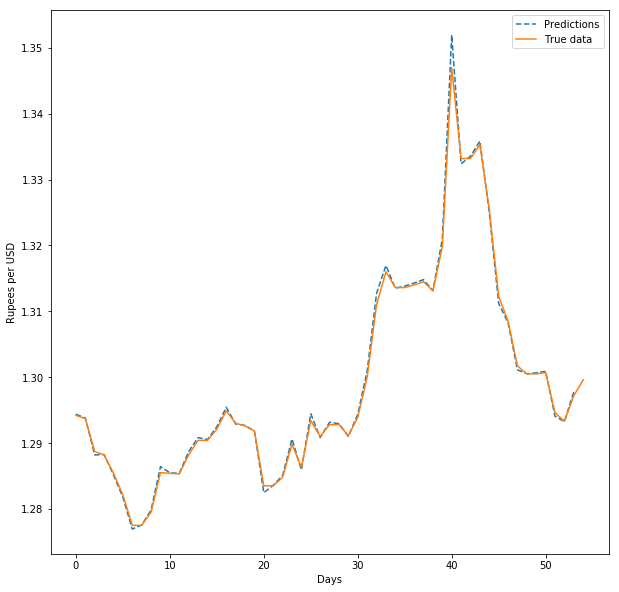

In [63]:
plt.plot(np.exp(predictions)[1:],'--',label='Predictions')
plt.plot(np.exp(test),label='True data')
#plt.plot(np.exp(full_predictions),label='Full prediction')
plt.ylabel('Rupees per USD')
plt.xlabel('Days')
plt.legend()
plt.plot()

print ('Mean squared error: {0:3f}'.format(MSE(np.exp(test),np.exp(predictions))))

In [64]:
#Tomorrow's value
train = list(data1)

train_list = [x for x in train]
predictions = []

model = ARIMA(np.array(train),order=(1,1,0))
fit = model.fit()
forecast = float(fit.forecast()[0])

tomorrow_value = np.exp(forecast)

# Today's value

rate_data_log = rate_data_log[:-1]
data1 = rate_data_log.values
train = list(data1)

train_list = [x for x in train]
predictions = []

model = ARIMA(np.array(train),order=(1,1,0))
fit = model.fit()
forecast = float(fit.forecast()[0])
today_value = np.exp(forecast)



/Users/ameyapatankar/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/ameyapatankar/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/ameyapatankar/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. I

In [65]:
rate_data.tail()


,Rate
Day,
2019-12-22,1.3007
2019-12-23,1.2946
2019-12-24,1.2933
2019-12-25,1.2972
2019-12-26,1.2996


In [66]:
print ("Today's actual value is {0:3f} and model predicted {1:3f}.".format(rate_data.values[-1][0],today_value))
print ("Model predicts value will be {0:3f} tomorrow.".format(tomorrow_value))

Today's actual value is 1.299600 and model predicted 1.297770.
Model predicts value will be 1.300017 tomorrow.


### Predicting for 30 days in advance

/Users/ameyapatankar/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/ameyapatankar/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/ameyapatankar/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. I

Mean squared error: 0.000315


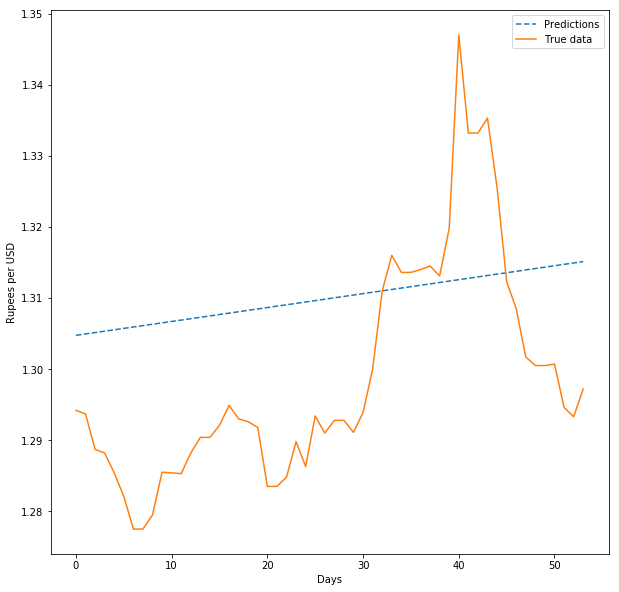

In [73]:
train_list = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(np.array(train),order=(1,1,0))
    fit = model.fit()
    forecast = float(fit.forecast()[0])
    predictions.append(forecast)
    train.append(float(forecast))

predictions = fit.forecast(len(test))[0]
plt.plot(np.exp(predictions),'--',label='Predictions')
plt.plot(np.exp(test),label='True data')
#plt.plot(np.exp(full_predictions),label='Full prediction')
plt.ylabel('Rupees per USD')
plt.xlabel('Days')
plt.legend()
plt.plot()

print ('Mean squared error: {0:3f}'.format(MSE(np.exp(test),np.exp(predictions))))


In [74]:
data1 = rate_data_log.values
train = list(data1[0:125])
test = list(data1[125:])


In [79]:
def gen_XY(t_list,size):
    '''
    Generates an autoregressive lagged array.
    
    Parameters
    ----------
    1. t_list: (list) Data to generate an autoregressive array out of.
    2. size: (int) Number of lagged values to consider.
    
    Returns
    ----------
    1. X: (np.ndarray) Autoregressive feature array.
    2. Y.T: (np.ndarray) Column array with values of response variable.
    
    '''
    X = np.zeros([1,size])
    Y = []
    temp_list=[]
    for i in range(len(t_list)-size):
        add_list = t_list[i:i+size]
        target = t_list[i+size]
        X = np.append(X,np.array([add_list]),axis=0)
        Y.append(target)
        
    X = np.delete(X,0,axis=0)
    Y = np.array(Y)
    
    return X,Y.T


In [80]:
X_train,y_train = gen_XY(train,1)
X_test,y_test = gen_XY(test,1)

### 1 Hidden Layers with 1 neuron and relu activation function

In [81]:
K.clear_session()
model = Sequential()
model.add(Dense(1, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

Epoch 1/20
124/124 [==============================] - 0s 784us/step - loss: 0.0115
Epoch 2/20
124/124 [==============================] - 0s 88us/step - loss: 0.0095
Epoch 3/20
124/124 [==============================] - 0s 67us/step - loss: 0.0078
Epoch 4/20
124/124 [==============================] - 0s 122us/step - loss: 0.0063
Epoch 5/20
124/124 [==============================] - 0s 61us/step - loss: 0.0050
Epoch 6/20
124/124 [==============================] - 0s 112us/step - loss: 0.0039
Epoch 7/20
124/124 [==============================] - 0s 82us/step - loss: 0.0030
Epoch 8/20
124/124 [==============================] - 0s 74us/step - loss: 0.0023
Epoch 9/20
124/124 [==============================] - 0s 118us/step - loss: 0.0017
Epoch 10/20
124/124 [==============================] - 0s 127us/step - loss: 0.0013
Epoch 11/20
124/124 [==============================] - 0s 125us/step - loss: 9.2327e-04
Epoch 12/20
124/124 [==============================] - 0s 115us/step - loss: 6.7632e-0

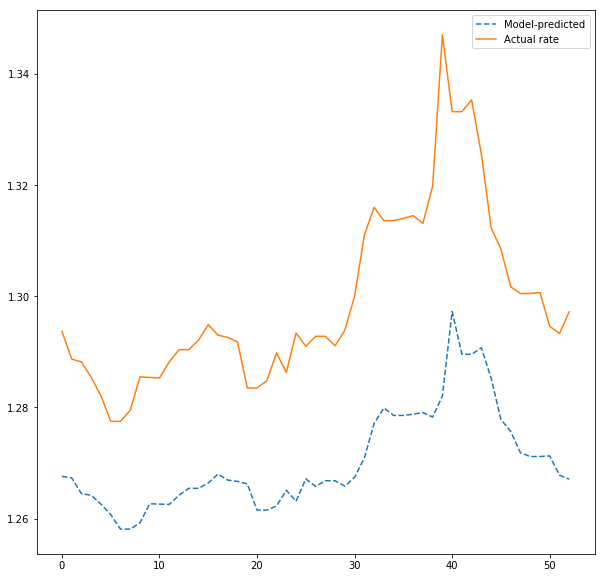

MSE: 0.000891


In [82]:
y_pred  =  model.predict(X_test)
plt.plot(np.exp(y_pred),'--',label='Model-predicted')
plt.plot(np.exp(y_test),label='Actual rate')
plt.legend()
plt.show()
print('MSE: %f'%(MSE(np.exp(y_test), np.exp(y_pred))))

### 2 Hidden Layers with 50 neurons each and ReLU activation function

In [83]:
K.clear_session()
model = Sequential()
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

Epoch 1/20
124/124 [==============================] - 0s 1ms/step - loss: 0.0011
Epoch 2/20
124/124 [==============================] - 0s 75us/step - loss: 3.2624e-04
Epoch 3/20
124/124 [==============================] - 0s 132us/step - loss: 1.5846e-04
Epoch 4/20
124/124 [==============================] - 0s 126us/step - loss: 7.9206e-05
Epoch 5/20
124/124 [==============================] - 0s 213us/step - loss: 5.1501e-05
Epoch 6/20
124/124 [==============================] - 0s 153us/step - loss: 3.3589e-05
Epoch 7/20
124/124 [==============================] - 0s 94us/step - loss: 2.4581e-05
Epoch 8/20
124/124 [==============================] - 0s 173us/step - loss: 2.3501e-05
Epoch 9/20
124/124 [==============================] - 0s 132us/step - loss: 2.4025e-05
Epoch 10/20
124/124 [==============================] - 0s 122us/step - loss: 2.4563e-05
Epoch 11/20
124/124 [==============================] - 0s 96us/step - loss: 2.5464e-05
Epoch 12/20
124/124 [=============================

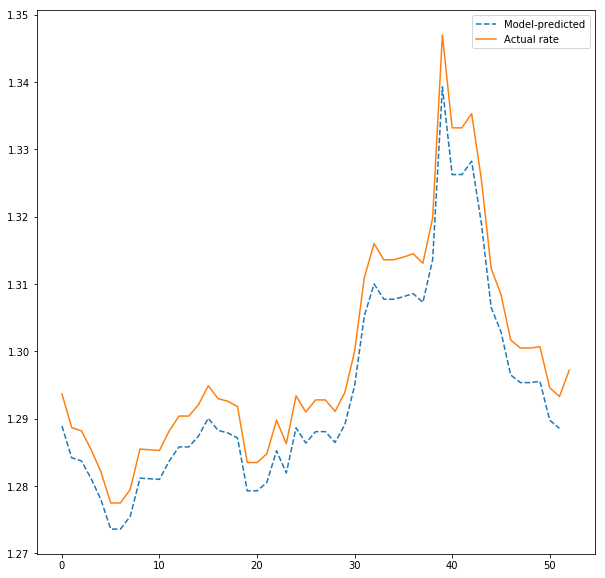

MSE: 0.000060


In [84]:
y_pred  =  model.predict(X_test)
plt.plot(np.exp(y_pred)[1:],'--',label='Model-predicted')
plt.plot(np.exp(y_test),label='Actual rate')
plt.legend()
plt.show()
print('MSE: %f'%(MSE(np.exp(y_test), np.exp(y_pred))))

### LSTM- Recurrent Neural Network (LSTM-RNN)

In [85]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [86]:
X_tr_t.shape

(124, 1, 1)

In [87]:
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(10, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(10,input_shape=(1, X_train.shape[1]), activation='relu'))

model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/200
124/124 [==============================] - 1s 7ms/step - loss: 0.0057
Epoch 2/200
124/124 [==============================] - 0s 2ms/step - loss: 1.3319e-04
Epoch 3/200
124/124 [==============================] - 0s 2ms/step - loss: 1.2116e-04
Epoch 4/200
124/124 [==============================] - 0s 2ms/step - loss: 1.1455e-04
Epoch 5/200
124/124 [==============================] - 0s 2ms/step - loss: 1.1129e-04
Epoch 6/200
124/124 [==============================] - 0s 2ms/step - loss: 1.0972e-04
Epoch 7/200
124/124 [==============================] - 0s 2ms/step - loss: 1.0908e-04
Epoch 8/200
124/124 [==============================] - 0s 2ms/step - loss: 1.0898e-04
Epoch 9/200
124/124 [==============================] - 0s 2ms/step - loss: 1.0930e-04
Epoch 10/200
124/124 [==============================] - 0s 2ms/step - loss: 1.0943e-04
Epoch 11/200
124/124 [==============================] - 0s 2ms/step - loss: 1.0977e-04
Epoch 12/200
124/124 [==============================] - 

In [88]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)

print("The MSE on the Train set is:\t{:0.3f}".format(MSE(np.exp(y_train), np.exp(y_train_pred_lstm))))
print("The MSE on the Test set is:\t{:0.3f}".format(MSE(np.exp(y_test), np.exp(y_pred_test_lstm))))

The MSE on the Train set is:	0.002
The MSE on the Test set is:	0.000


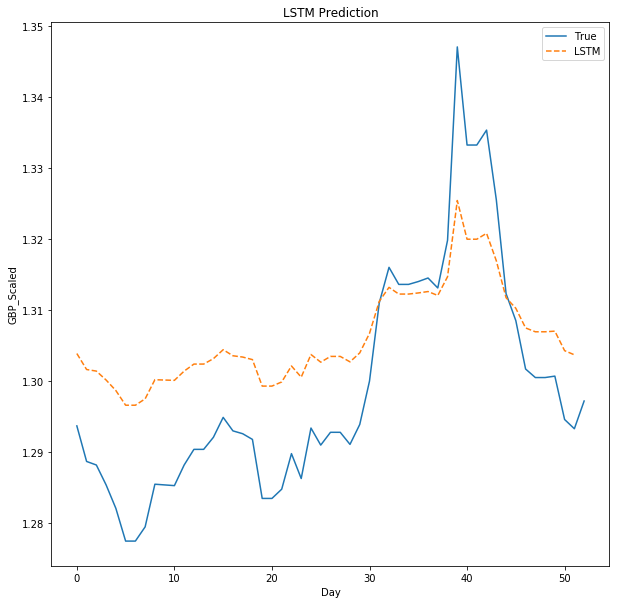

In [89]:
plt.plot(np.exp(y_test), label='True')
plt.plot(np.exp(y_pred_test_lstm)[1:],'--',label='LSTM')
plt.title("LSTM Prediction")
plt.xlabel('Day')
plt.ylabel('GBP_Scaled')
plt.legend()
plt.show()

